In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import glob
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
from sklearn.decomposition import PCA
from deterministic_annealing import AssignmentAnnealing, assignment_iteration
import time
import scipy

np.random.seed(42)

import importlib
importlib.reload(stats)

<module 'stats' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/stats.py'>

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/'
# f = h5py.File(path_to_filtered_data+'filtered_data.h5','r')
f = h5py.File(path_to_filtered_data+'filtered_phdata9_condition_3.h5','r')
# f = h5py.File(path_to_filtered_data+'filtered_phdata_condition_1.h5','r')
# f = h5py.File(path_to_filtered_data+'filtered_phdata_condition_2.h5','r')
# print(list(f.keys()))
# print(list(f['MetaData'].keys()))
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
bout_dur_for_pca = np.array(f['MetaData/bout_duration_for_pca'],dtype=int)[0] #bout duration
frameRate = np.array(f['MetaData/frameRate'])[0] #sampling frame rate
ph_idx = np.array(f['MetaData/ph_idx'])
#min_bouts = np.array(f['MetaData/min_bouts'],dtype=int)[0] #mininum number of bouts per fish
# bouttypes = ma.array(f['MetaData/bout_types'])
# motifs = ma.array(f['MetaData/motifs'])
t0_bout = np.array(f['MetaData/t0_bout'],dtype=int)[0] #initial time bout
time_Bout = ma.array(f['times_bouts']) #raw times bouts
#shapes are n_fish, max_n_bouts,dim of variable
X_head = ma.array(f['head_pos'])
phi_raw = ma.array(f['orientation_raw'])
phi_smooth = ma.array(f['orientation_smooth'])
pca_fish = ma.array(f['pca_fish'])
pca_raw_fish = ma.array(f['pca_raw_fish'])
speeds_head = ma.array(f['speed_head'])
tail_angles_raw = ma.array(f['tail_angle_raw'])
tail_angles_smooth = ma.array(f['tail_angle_smooth'])
tail_angles_speed = ma.array(f['tail_angle_speed'])
thetas_aligned = ma.array(f['tail_angles_aligned'])
thetas_raw = ma.array(f['tail_angles_raw'])
skeletons = ma.array(f['tail_points_xy'])
f.close()

In [6]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/'
f = h5py.File(path_to_filtered_data + 'filtered_phdata9_condition_3/kmeans_labels_K7_N1100.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish_allrec = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

In [7]:
start_rec = 0
end_rec = 218

cond_recs = np.arange(start_rec,end_rec)
# cond_recs = np.where(lengths_all >= 250)[0]

to_mask = 1200

maxL = np.max(lengths_all)

labels_fish_allrec[labels_fish_allrec == to_mask] = ma.masked

labels_fishrec = to_mask * ma.ones((len(cond_recs), maxL))
labels_fishrec = labels_fish_allrec[cond_recs,:maxL+2]
# labels_fishrec = np.delete(labels_fishrec,4,0)

labels_fishrec[labels_fishrec == to_mask] = ma.masked
labels_fish = labels_fishrec

In [8]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,20)
delay_range = np.arange(1,20,1)
dt = 1
div= 218
n_modes=10
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(218, 946)


In [9]:
def sampler(labels_fish, ph_idx ,lengths_all, window_size, to_mask, s):
    np.random.seed(s)
#     condition_recs = np.array([[0,281],[281,584]])
    sampled_labels = []
    for cond in range(2):
        cond_recs = np.where(ph_idx == cond)[0]
        samples_ = to_mask*ma.ones((window_size+4,), dtype=int)
        labels_cond = labels_fish[cond_recs]
        rec_list = []
        for i, l in enumerate(lengths_all[cond_recs]):
            labels_cond[i,l-2:l] = ma.masked
            rec_list.append(labels_cond[i,:l])
        
        labels_ = ma.hstack(rec_list)
        start_pos = np.random.randint(0, len(labels_)-window_size)
        
        samples_[2:-2] = labels_[start_pos:start_pos+window_size]
        samples_[samples_==to_mask] = ma.masked
        sampled_labels.append(samples_)
    return sampled_labels

## Compute implied time scales

In [12]:
## Calculate by sampling similar number of bouts from each condition

ts_traj_delay = ma.zeros((seeds.shape[0],len(delay_range),n_modes))
eigvals_shuffle = ma.zeros((seeds.shape[0],n_modes))

window_size = 40000

for i,s in enumerate(seeds):
    print(s)
    labels_bootstrap = sampler(labels_fish, ph_idx,lengths_all, window_size, to_mask, s)
    labels_ = ma.hstack(labels_bootstrap)
    nstates = ma.max(labels_) + 1
    segments = op_calc.segment_maskedArray(labels_)

    dtrajs = np.asarray([labels_[t0:tf] for t0,tf in segments])
    if ma.count(labels_)>20:
        for kd,delay in enumerate(delay_range):
            ts_traj_delay[i,kd,:] = op_calc.implied_tscale_shuffle(dtrajs,nstates,delay,dt,n_modes,reversible=True)

#     labels_shuffle = labels_[np.random.choice(np.arange(len(labels_)),len(labels_))]
#     P_shuffle = op_calc.transition_matrix(labels_shuffle,1)
    P_shuffle = op_calc.transition_matrix_shuffle(dtrajs,1)
    R_shuffle = op_calc.get_reversible_transition_matrix(P_shuffle)
    eigvals,eigvecs = op_calc.sorted_spectrum(R_shuffle,k=n_modes+1)
    sorted_indices = np.argsort(eigvals.real)[::-1]
    eigvals = eigvals[sorted_indices][1:].real
    eigvals[np.abs(eigvals-1)<1e-12] = np.nan
    eigvals[eigvals<1e-12] = np.nan
    eigvals_shuffle[i,:] = eigvals

7270


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


860
5390
5191
5734
6265
466
4426
5578
8322
1685
769
6949
2433
5311
5051
6420
1184
4555
3385


In [17]:
ts_traj_delay[ts_traj_delay==0] = ma.masked
eigvals_shuffle[eigvals_shuffle == 0] = ma.masked 

## Use if sampling similar number of bouts from each condition

ts_traj_delay_total = ts_traj_delay
eigvals_shuffle_total = eigvals_shuffle

# Use if sampling whole recordings

# ts_traj_delay_total = ma.concatenate(ts_traj_delay, axis=0)
# eigvals_shuffle_total = ma.concatenate(eigvals_shuffle, axis=0)

In [18]:
print(ts_traj_delay_total.shape)
print(eigvals_shuffle_total.shape)

(20, 19, 10)
(20, 10)


In [19]:
print(delay_range)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


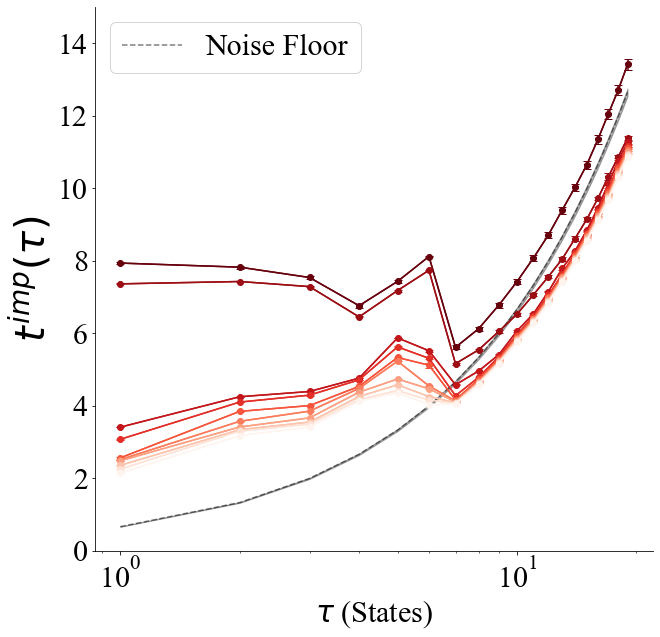

In [21]:
# time scales
colors_ = plt.cm.Reds_r(np.linspace(0,1,n_modes))

fig, ax = plt.subplots(1,1,figsize=(10,10))
for mode in range(n_modes):
    mean = ma.mean(ts_traj_delay_total[:,:,mode],axis=0)
#     cil = np.nanpercentile(ts_traj_delay_total[:,:,mode],2.5,axis=0)
#     ciu = np.nanpercentile(ts_traj_delay_total[:,:,mode],97.5,axis=0)
    mean,cil,ciu=stats.bootstrap(ts_traj_delay_total[:,:,mode].squeeze(),median=False,n_times=1000)
    ax.plot(delay_range*dt,mean,c=colors_[mode], marker='*')
    ax.errorbar(delay_range*dt, mean,[mean-cil, ciu - mean], marker='o', capsize=4, color = colors_[mode])
#     ax.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])
# plt.xscale('log')
# mean,cil,ciu = stats.bootstrap(eigvals_shuffle,n_times=100)
# mean = eigvals_shuffle[:,0].mean()
# cil = np.percentile(eigvals_shuffle[:,0],2.5)
# ciu = np.percentile(eigvals_shuffle[:,0],97.5)
tscales_shuffle = np.array([-d/np.log(eigvals_shuffle_total[:,0]) for d in delay_range])
mean,cil,ciu = stats.bootstrap(tscales_shuffle.T,n_times=100)
# mean = tscales_shuffle.mean(axis=1)
# cil = np.percentile(tscales_shuffle,2.5,axis=1)
# ciu = np.percentile(tscales_shuffle,97.5,axis=1)
#noise floor
# ax.plot(delay_range*dt,-delay_range/np.log(mean),c='k',alpha=.5,ls='--', label='Noise Floor')
# ax.fill_between(delay_range*dt,-delay_range/np.log(cil),-delay_range/np.log(ciu),color='k',alpha=.3)
ax.plot(delay_range*dt,mean,c='k',alpha=.5,ls='--', label='Noise Floor')
ax.fill_between(delay_range*dt,cil,ciu,color='k',alpha=.3)
ax.legend(fontsize = 30)
ax.set_xlabel(r'$\tau$ (States)',fontsize=30)
ax.set_ylabel(r'$t^{imp} (\tau)$',fontsize=40)
# ax.axvline(1,ls='--',c='r')
# ax.axvline(4,ls='--',c='r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('Implied Timescales', fontsize=40)
# plt.colorbar()
# ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xticks(np.arange(1,11))
# plt.xlim(0,2000)
# ax.set_xlim(7,20)
ax.set_ylim(0,15)
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.ylim(0,20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/implied_timescales.pdf')
plt.show()

(array([1., 2., 3., 4., 5., 6., 7., 8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

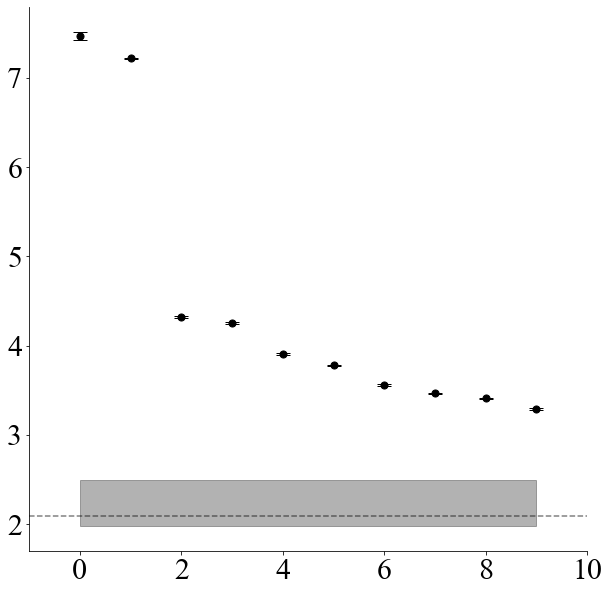

In [11]:
colors_ = plt.cm.Reds_r(np.linspace(0,1,n_modes))

fig, ax = plt.subplots(1,1,figsize=(10,10))

tau = 3

ts_traj_delay1 = ts_traj_delay_total[:,tau-1,:]

# for mode in range(n_modes):
mean,cil,ciu=stats.bootstrap(ts_traj_delay1[:,:],median=False,n_times=1000)
ax.scatter(np.arange(n_modes),mean,c='k', s =50)
ax.errorbar(np.arange(n_modes), mean,[mean-cil, ciu - mean], fmt='.', capsize=7, elinewidth=3, color = 'k')

# ax.legend(fontsize = 30)
# ax.set_facecolor('k')

mean = tscales_shuffle.mean(axis=1)
cil = np.percentile(tscales_shuffle,2.5,axis=1)
ciu = np.percentile(tscales_shuffle,97.5,axis=1)
ax.axhline(mean[tau-1],c='k',alpha=.5,ls='--', label='Noise Floor')
# ax.axhline(ciu[tau-1],c='k',alpha=.5,ls='--', label='Noise Floor')
# ax.axhline(cil[tau-1],c='k',alpha=.5,ls='--', label='Noise Floor')
ax.fill_between(np.arange(n_modes),cil[tau-1]*np.ones(n_modes),ciu[tau-1]*np.ones(n_modes),color='k',alpha=.3)

# ax.set_xlabel(r'$\phi_k$',fontsize=40)
# ax.set_ylabel(r'$t^{imp}_k (\tau = 3)$(bouts)',fontsize=40)
# ax.set_xticks(np.arange(0,12,4))
# ax.set_xticklabels(np.arange(1,12,4,dtype=int))
# ax.axvline(1,ls='--',c='r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xticklabels(['',''], fontsize=30, rotation=70)
# ax.set_yticklabels(['',''], fontsize=30)

# plt.colorbar()
# ax.set_xscale('log')
# ax.set_xticks(np.arange(30))
# ax.set_xticklabels(np.arange(2,32))
# plt.xlim(2*dt,20)
ax.set_xlim(-1,10)
# ax.set_ylim(3,8)
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.ylim(0,20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig2/implied_timescales_t3_jm_forward.pdf')
# plt.show() 

In [12]:
eigvals_traj_delay_total = np.copy(ts_traj_delay_total)
for traj_idx in range(ts_traj_delay_total.shape[0]):
    eigvals_traj_delay_total[traj_idx,:,:] = np.exp(-(delay_range*dt)/ts_traj_delay_total[traj_idx,:,:].T).T

In [13]:
print(eigvals_traj_delay_total.shape)

(20, 19, 10)


[ 3  6  9 12 15 18]
[0.44775658 0.20048596 0.08976891 0.04019462 0.01799741 0.00805846
 0.00360823 0.00161561 0.0007234 ]


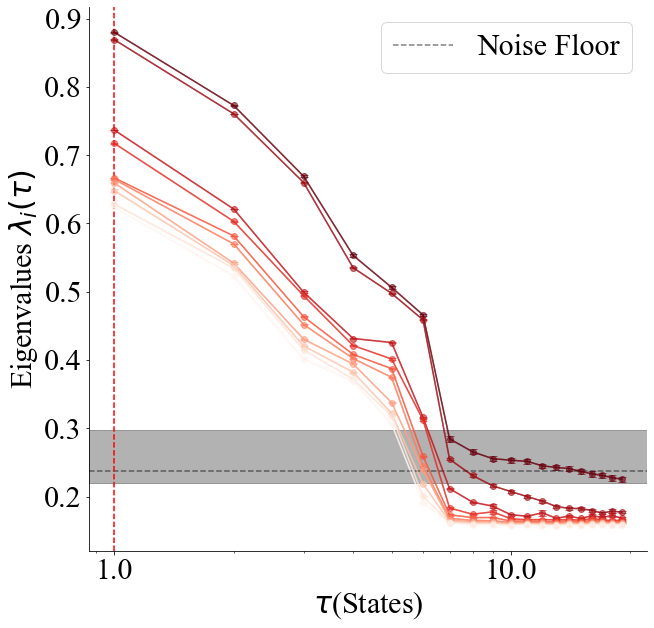

In [14]:
# eigenvalues
colors_ = plt.cm.Reds_r(np.linspace(0,1,n_modes))

fig, ax = plt.subplots(1,1,figsize=(10,10))
tau_ = 3
for mode in range(n_modes):
    mean,cil,ciu=stats.bootstrap(eigvals_traj_delay_total[:,:,mode],median=False,n_times=1000)
    if mode == 0:
        l_ = mean[tau_-1]
        c1_ = cil[tau_-1]
        c2_ = ciu[tau_-1]
#     print(mean)
    ax.plot(delay_range*dt,mean,c=colors_[mode], alpha=.6)
    ax.errorbar(delay_range*dt, mean,[mean-cil, ciu - mean], marker='o', capsize=4, color = colors_[mode], alpha=0.6)
#     ax.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])

# tau_ = 1
# cil = np.percentile(,2.5,axis=1)
# ciu = np.percentile(tscales_shuffle,97.5,axis=1)
print(delay_range[tau_-1::tau_])
print(l_**delay_range[1::2])
# ax.plot(delay_range[tau_-1::tau_]*dt,l_**delay_range[:len(delay_range[tau_-1::tau_])],c='k',marker='*', lw = 2, markersize=10)
# ax.fill_between(delay_range[tau_-1::tau_]*dt,c1_**delay_range[:len(delay_range[tau_-1::tau_])],c2_**delay_range[:len(delay_range[tau_-1::tau_])], color='k',alpha=.2)

#noise floor
# mean,cil,ciu = stats.bootstrap(eigvals_shuffle,n_times=1000)
mean = eigvals_shuffle_total[:,0].mean()
cil = np.percentile(eigvals_shuffle_total[:,0],2.5)
ciu = np.percentile(eigvals_shuffle_total[:,0],97.5)
ax.axhline(mean,c='k',alpha=.5,ls='--', label='Noise Floor')
ax.axhspan(cil,ciu,color='k',alpha=.3)
ax.axvline(1,ls='--',c='r')
ax.legend(fontsize = 30)
# plt.axhline(mean[1],c='k',alpha=.5,ls='--')
# plt.axhspan(cil[1],ciu[1],color='k',alpha=.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xscale('log')
# ax.set_xlim(0,20)
# ax.set_xticks(np.arange(1,11))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.xlim(1*dt,5)
ax.set_xlabel(r'$\tau$(States)',fontsize=30)
ax.set_ylabel(r'Eigenvalues $\lambda_i(\tau)$',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.ylim(0.4,1)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig2/eigenvalues_jm.pdf')
plt.show()

In [15]:
print(seeds)

[7270  860 5390 5191 5734 6265  466 4426 5578 8322 1685  769 6949 2433
 5311 5051 6420 1184 4555 3385]


In [10]:
# Sample equal number of bouts from each condition to find coherence based partition point

np.random.seed(42)
seeds = np.random.randint(0,10000,100)
window_size = 40000
delay = 3
dt = 1
print(delay)

Ps = np.zeros((len(seeds),1100,1100))

phi2s = []
eigs = []
c_ranges = []
rhos = []
ms = []
splits = []
rec_idxs = []

for cf,s in enumerate(seeds):
    print(s)
    labels_bootstrap = sampler(labels_fish, ph_idx,lengths_all, window_size,to_mask,s)
    print(np.unique(labels_bootstrap).shape)
    labels_ = ma.hstack(labels_bootstrap)
    lcs,P = op_calc.transition_matrix(labels_,delay,return_connected=True)
    for i,l in enumerate(lcs):
        Ps[cf, l,lcs] = P.todense()[i]

P_avg = Ps.mean(axis=0)
row_sums = P_avg.sum(axis=1)
P_ensemble = P_avg / row_sums[:, np.newaxis]

3
7270
(1101,)
860
(1101,)
5390
(1101,)
5191
(1101,)
5734
(1101,)
6265
(1101,)
466
(1101,)
4426
(1101,)
5578
(1101,)
8322
(1101,)
1685
(1101,)
769
(1101,)
6949
(1101,)
2433
(1101,)
5311
(1101,)
5051
(1101,)
6420
(1101,)
1184
(1101,)
4555
(1101,)
3385
(1101,)
6396
(1101,)
8666
(1101,)
9274
(1101,)
2558
(1101,)
7849
(1101,)
2047
(1101,)
2747
(1101,)
9167
(1101,)
9998
(1101,)
189
(1101,)
2734
(1101,)
3005
(1101,)
4658
(1101,)
1899
(1101,)
7734
(1101,)
1267
(1101,)
1528
(1101,)
3556
(1101,)
3890
(1101,)
8838
(1101,)
5393
(1101,)
8792
(1101,)
8433
(1101,)
7513
(1101,)
2612
(1101,)
7041
(1101,)
9555
(1101,)
6235
(1101,)
5486
(1101,)
7099
(1101,)
9670
(1101,)
775
(1101,)
8226
(1101,)
3152
(1101,)
1585
(1101,)
3943
(1101,)
7555
(1101,)
3073
(1101,)
1021
(1101,)
3843
(1101,)
7989
(1101,)
9692
(1101,)
6873
(1101,)
5675
(1101,)
161
(1101,)
4297
(1101,)
995
(1101,)
7629
(1101,)
9467
(1101,)
1016
(1101,)
7869
(1101,)
6439
(1101,)
7892
(1101,)
6863
(1101,)
7916
(1101,)
8529
(1101,)
878
(1101,)
9268


In [12]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [13]:
# Perform coherence based split on whole dataset
# np.random.seed(25)
import msmtools.estimation as msm_estimation
delay = 3
dt = 1
print(delay)
# lcs_ensemble,P_full = op_calc.transition_matrix(labels_all,delay,return_connected=True)
lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)
R = op_calc.get_reversible_transition_matrix(P_ensemble)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=43)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]
c_range_phi1,rho_sets,measures,split_idx_phi1,coh_labels_phi1 = op_calc.optimal_partition(phi1,inv_measure,P_ensemble,return_rho=True)
c_range_phi2,_,_,split_idx_phi2,coh_labels_phi2 = op_calc.optimal_partition(phi2,inv_measure,P_ensemble,return_rho=True)
# c_range_phi4,_,_,split_idx_phi4,coh_labels_phi4 = op_calc.optimal_partition(phi4,inv_measure,P_ensemble,return_rho=True)

print(c_range_phi1[split_idx_phi1])

3
-0.011053021178487218


In [14]:
eigvals,eigvecs = op_calc.sorted_spectrum(P_ensemble,k=10,seed=43)
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))

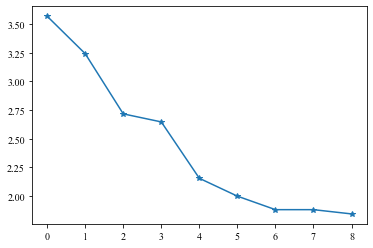

In [15]:
# Visualize implied timescales on whole operator
plt.plot(t_imp, marker='*')

In [16]:
print(rho_sets.shape)

(1098, 2)


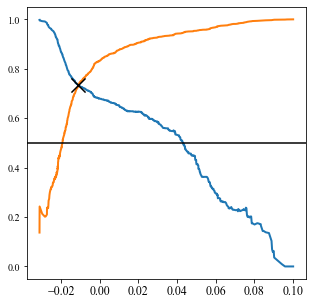

In [17]:
plt.figure(figsize=(5,5))
for i in range(2):
    plt.plot(c_range_phi1,rho_sets[:,i],lw=2)
rho_c = np.min(rho_sets,axis=1)
plt.scatter(c_range_phi1[split_idx_phi1],rho_c[split_idx_phi1],c='k',marker='x',s=200, zorder=30)
# plt.axvline(-0.015)
# plt.axvline(0.001)
# plt.plot(c_range_phi2,rho_c,c='k',marker='*', alpha =.5)
# plt.ylim(.7,0.9)
# plt.xlim(-0.02,0.015)

# plt.xlabel(r'$\phi_2$',fontsize=15)
# plt.ylabel(r'$\rho$',fontsize=15)
plt.axhline(0.5, c='k')
plt.xticks(fontsize=12)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/coherence.pdf')
plt.show()

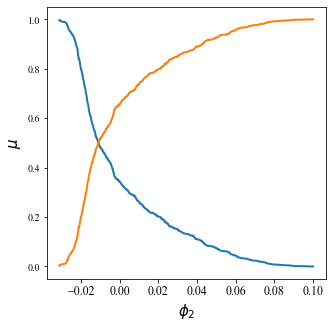

In [18]:
# Plot measure preserved in each metastate

plt.figure(figsize=(5,5))
plt.plot(c_range_phi1,measures,lw=2)
rho_c = np.min(measures,axis=1)
# plt.scatter(c_range[split_idx],measures[split_idx],c='r',marker='x',s=100)
# plt.plot(c_range,measures,c='k',marker='*', alpha =.5)
# plt.ylim(.5,0.9)
# plt.xlim(-0.02,0.005)

plt.xlabel(r'$\phi_2$',fontsize=15)
plt.ylabel(r'$\mu$',fontsize=15)
plt.xticks(fontsize=12)
# plt.savefig('Results/Condition1/state_partition.png')
plt.show()

In [19]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [22]:
distort_traj = ma.array(distorted_eigfs[:,0])[final_labels]
distort_traj[final_labels.mask] = ma.masked
dtrajs_fish_phi1 = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

distort_traj = ma.array(distorted_eigfs[:,1])[final_labels]
distort_traj[final_labels.mask] = ma.masked
dtrajs_fish_phi2 = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

In [103]:
cond = 1
cond_recs = np.where(ph_idx == cond)[0]

all_headX_cond = ma.concatenate(X_head[cond_recs,:],axis=0)
all_headX_cond[all_headX_cond==0] = ma.masked

all_head_start = all_headX_cond[:,0,1]
nonph_idx = np.where(np.logical_and(all_head_start<1500, all_head_start>500))[0]

In [104]:
print(all_head_start.shape)

(89870,)


<ipython-input-105-458165edfcfb>:22: UserWarning: linewidths is ignored by contourf
  im = ax.contourf(X,Y, img, cmap='Reds', linewidths=2, levels = 17)


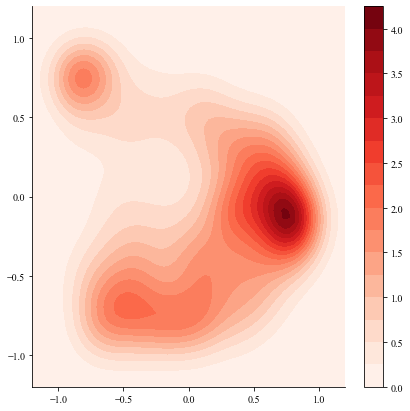

In [105]:
fig, ax  = plt.subplots(1,1,figsize=(7, 7))

# psi1[ecs_all.mask] = ma.masked
# psi2[ecs_all.mask] = ma.masked

xrange=[-1.2, +1.2]
yrange=[-1.2, +1.2]

all_head_start

psi1 = ma.concatenate(dtrajs_fish_phi1[cond_recs,:], axis=0)
psi2 = -1*ma.concatenate(dtrajs_fish_phi2[cond_recs,:], axis=0)

psi1[nonph_idx] = ma.masked # Mask nonph 
psi2[nonph_idx] = ma.masked

# img= stats.density_plot(psi1.compressed()[::100], psi2.compressed()[::100], xrange, yrange, 50,50,smooth=True, border=3)

img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 60,60,smooth=True, border=4)

X,Y = np.meshgrid(np.linspace(-1.2,1.2,68), np.linspace(-1.2,1.2,68))
im = ax.contourf(X,Y, img, cmap='Reds', linewidths=2, levels = 17)
fig.colorbar(im)


# im = ax.imshow(img, cmap='inferno', origin='lower')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/nonph_mes.pdf')

# plt.imshow(img, cmap='inferno', origin='lower')
# plt.colorbar()
# ax = plt.axes(projection='3d')
# # surf = ax.plot_surface(yy, xx, zz, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
# ax.scatter(phi3, phi2, zs=0, c=probs, cmap='coolwarm', alpha=0.5)
# ax.set_xlabel('$\phi_1$')
# ax.set_ylabel('$\phi_2$')
# ax.set_zlabel('PDF')
# ax.set_title('Surface plot of Gaussian 2D KDE')
# fig.colorbar(im,ax = ax) # add color bar indicating the PDF
# ax.view_init(60, 35)
# plt.show()

In [106]:
sort_clus_idx = np.argsort(coh_labels_phi1)[::-1]

(-0.5, 1099.5, 1099.5, -0.5)

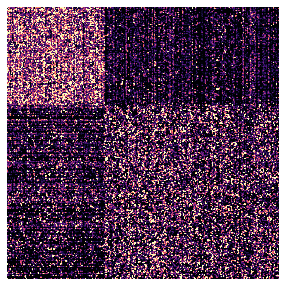

In [107]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
D2 = copy.deepcopy(P_ensemble.todense())
D2[:] = D2[sort_clus_idx,:]
D2[:] = D2[:,sort_clus_idx]

ax.imshow(D2, vmax = 0.003,cmap='magma')
ax.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/Tmat_WC.pdf')
# ax.colorbar()

In [108]:
st_names = ['Roaming','Cruising']#,'Cruising2']
# st_names = ['Metastate 1','Metastate 2']
st_colors = ['#1F50A3','#D04D49']
# st_cms = ['Blues', 'Reds']

In [109]:
kmeans_labels = coh_labels_phi1
# kmeans_labels = kmeans_labels_test
# kmeans_labels = kms2
# kmeans_labels = km.labels_

In [110]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

# cluster_fish = cluster_traj_all.reshape(12,4836)
cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

In [111]:
cond = 1

cond_recs = np.where(ph_idx == cond)[0]
# cond_recs = np.arange(218)

# start_rec = condition_recs[cond][0]
# end_rec = condition_recs[cond][1]

# a = np.arange(condition_recs[9][0],condition_recs[9][1])
# b = np.arange(condition_recs[5][0],condition_recs[5][1])

# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_all)

cluster_fish_condition = cluster_fish[cond_recs,:maxL]
# print(lengths_all[start_rec:end_rec].shape)
# maxL = np.max(lengths_all[start_rec:end_rec])

# cluster_fish_condition = cluster_fish[start_rec:end_rec,:maxL]

cluster_traj = ma.concatenate(cluster_fish_condition, axis=0)
# dtrajs_ = ma.concatenate(dtrajs_fish_condiion_, axis=0)
print(cluster_fish_condition.shape)
# cluster_traj = cluster_traj_all

(95, 946)


In [112]:
print(cluster_traj.shape)
print(psi1.shape)

(89870,)
(89870,)


In [113]:
cluster_traj[nonph_idx] = ma.masked

In [114]:
cluster_fish_condition = cluster_traj.reshape(95,946)

In [115]:
lifetimes_fish = [[],[],[],[],[],[],[],[]]
for cf in range(cluster_fish_condition.shape[0]):
    data_lifetimes, state_labels = stats.state_lifetime(cluster_fish_condition[cf],dt)
    for k,ks in enumerate(state_labels):
        if len(state_labels) == 1:
            print(len(lifetimes_fish[ks]),ks)
        lifetimes_fish[ks].append(data_lifetimes[k])

0 1
20 1
33 0
43 0
46 0
47 0
55 0
57 0
64 0
68 1
69 1
73 0
74 0
74 1


In [165]:
y_errorbar_metastate, x_all_metastate, m_all_metastate, b_all_metastate, tscales_metastate, params_metastate, mean_lifetimes = stats.state_lifetimes_stats(lifetimes_fish, n_states=2)

0


/Users/gautam.sridhar/Documents/Repos/ZebraBouts/utils/stats.py:476: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = cumulative_dist(np.hstack(np.random.choice(lifetimes_fish[ks],len(lifetimes_fish[ks]))),(t0,tf))


1


0
1


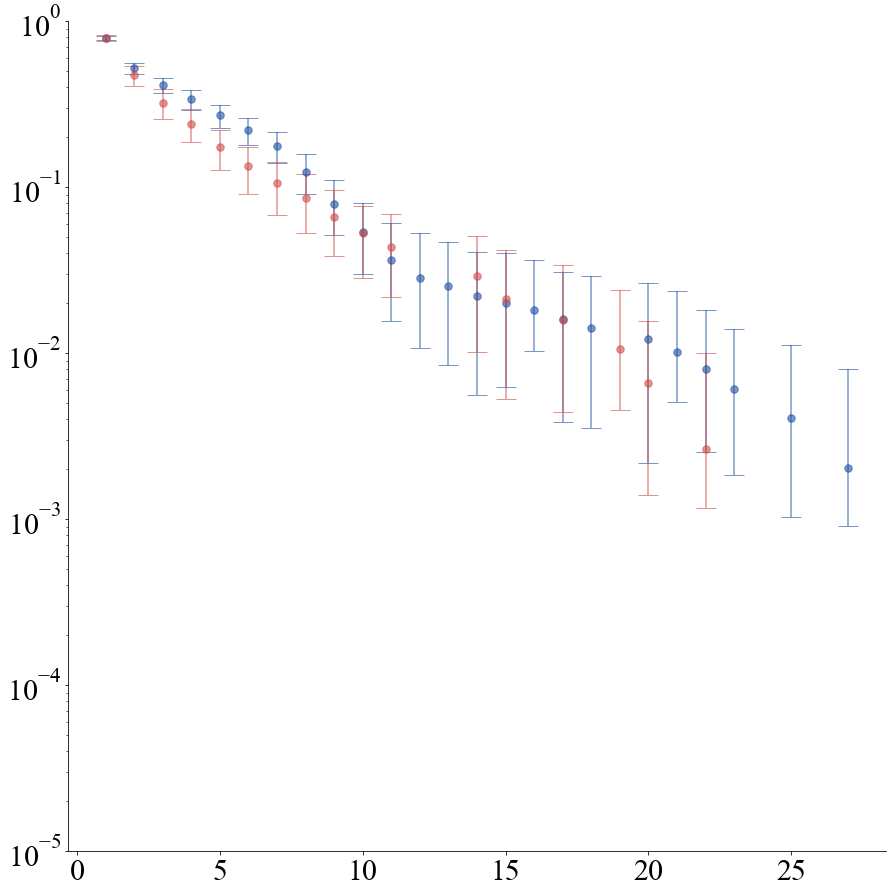

In [166]:
fig,ax = plt.subplots(1,1, figsize=(12.5,12.5))
t0,tf=1,600
xrange = np.linspace(t0,tf,160)
for ms in [0,1]:
    print(ms)

    mean = y_errorbar_metastate[ms][:-1,0]
    cil = y_errorbar_metastate[ms][:-1,1]
    ciu = y_errorbar_metastate[ms][:-1,2]
    
    params_cil = params_metastate[ms][0]
    params_ciu = params_metastate[ms][1]
    
#     ax.fill_between(xrange, np.exp(params_cil[0]*xrange+params_cil[1]), np.exp(params_ciu[0]*xrange + params_ciu[1]),color=st_colors[ms],alpha=0.05)
#     ax.plot(xrange,np.exp(m_all_metastate[ms]*xrange+b_all_metastate[ms]),
#             c='C{}'.format(ms),alpha=.3,label= r'$\tau_{}$ = {} bouts ({},{})'.format(ms, round(-1/m_all_metastate[ms], 2),round(tscales_metastate[ms][0],2),round(tscales_metastate[ms][1],2)),lw = 10)
#     ax.scatter(x_all_metastate[ms][:-1], y_errorbar_metastate[ms][:-1,0], s=50, color=st_colors[ms],label = r'Mean Duration$_{} = {}$ Bouts'.format({st_names[ms][0:2]}, round(mean_lifetimes[ms],2)))
    ax.errorbar(x_all_metastate[ms][:-1], mean,[mean-cil, ciu - mean],ms=15 ,fmt='.', capsize=10, color = st_colors[ms], alpha=0.6)
#     ax.fill_between(x_all_metastate[ms][:-1], y_errorbar_metastate[ms][:-1,1], y_errorbar_metastate[ms][:-1,2], alpha=0.2, color=st_colors[ms])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('log')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xscale('log')
# ax.set_xlabel(r'Bouts',fontsize=40)
# ax.set_ylabel(r'Complementary CDF (log scale)',fontsize= 40)
# ax.legend(loc="upper left", fontsize=40)
# ax.set_title('Condition {}'.format(condition_labels[8]), fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.set_xlim(-1,200)
ax.set_ylim(1e-5,1)
plt.tight_layout()

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/WC_dwelltime.pdf')
# plt.show()

In [118]:
phi_smooth[phi_smooth == 0] = ma.masked
# phis = ma.concatenate(phi_smooth, axis=0)

In [88]:
phis_fish = [[],[],[],[],[],[],[],[]]
for cf in range(cluster_fish_condition.shape[0]):
    for ks in np.unique(cluster_traj.compressed()):
        print(ks, cf)
        sel = cluster_fish_condition[cf - start_rec] == ks
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        print(segments)
        time.sleep(60)
        if len(segments) == 0:
            continue
        sorted_indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
        avg_orientation = [] 
        for idx in sorted_indices:
            t0,tf = segments[idx]
            for j in range(t0,tf):
                angle = phi_smooth[cf,j]
                angle2 = angle[~angle.mask]
                orient_diff = np.abs((angle2[-1] - angle[0])*(180/np.pi))
                avg_orientation.append(orient_diff)
        phis_fish[ks].append(ma.hstack(avg_orientation))

0 0
[[ 58  59]
 [ 61  62]
 [ 64  65]
 [ 68  77]
 [ 79  80]
 [116 126]
 [132 134]
 [135 139]
 [142 150]
 [164 170]
 [171 179]
 [180 181]
 [183 184]
 [196 207]
 [209 211]
 [255 266]
 [327 331]
 [365 366]
 [367 372]
 [423 430]
 [432 443]
 [519 520]
 [522 524]
 [580 581]
 [583 590]
 [664 670]
 [699 700]
 [702 703]
 [705 706]
 [707 708]
 [710 711]
 [713 714]
 [725 726]
 [753 754]]


KeyboardInterrupt: 

In [120]:
y_ebs_phis, x_all_phis = stats.dist_bootstrap(phis_fish, 0, 140, 2, 10)

/Users/gautam.sridhar/Documents/Repos/ZebraBouts/utils/stats.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = cumulative_dist(np.hstack(np.random.choice(statscollection_fish[ms],len(statscollection_fish[ms]))),(t0,tf))


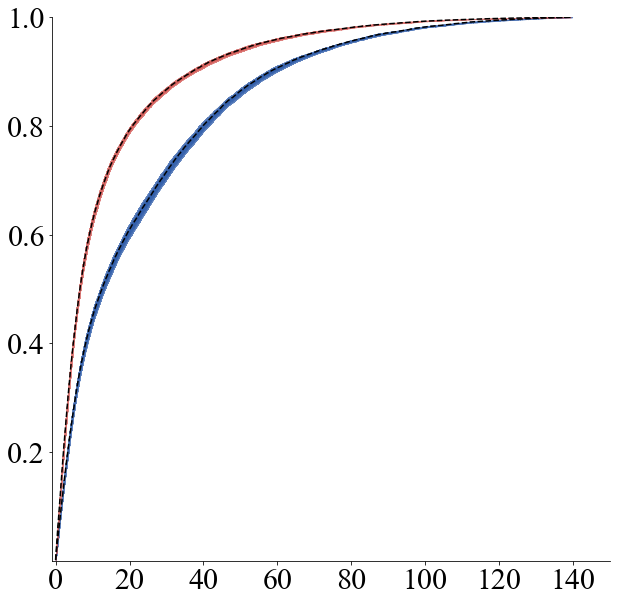

In [65]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

for ms in np.unique(cluster_traj_all.compressed()):
    mean = y_ebs_phis[ms][:-1,0]
    cil = y_ebs_phis[ms][:-1,1]
    ciu = y_ebs_phis[ms][:-1,2]
    ax.plot(x_all_phis[ms], 1-y_ebs_phis[ms][:,0], color='k', ls = '--', alpha=1.)
    ax.fill_between(x_all_phis[ms], 1-y_ebs_phis[ms][:,1], 1-y_ebs_phis[ms][:,2], alpha=0.7, color=st_colors[ms])
#     ax.errorbar(x_all_phis[ms][:-1], mean,[mean-cil, ciu - mean], fmt='.', capsize=10, color = st_colors[ms], alpha=0.2)
        
# ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_yscale('log')
# ax.set_xlabel(r'$\Delta$ Orientation per bout ($\circ$)',fontsize=35)
# ax.set_ylabel('CDF',fontsize= 40)
# ax.legend(loc="upper left",bbox_to_anchor=(1.0, 1.05), fontsize=40, ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_xlim(-1,150)
ax.set_ylim(1e-4,1)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/WC_heading.pdf')
# plt.show()/

In [105]:
speeds_head[speeds_head == 0] = ma.masked

speeds_fish = [[],[],[],[],[],[],[],[]]

ps = 0.0071 #cm

for i, ks in enumerate([0,1]):
    print(ks)
    for cf in range(cluster_fish_condition.shape[0]):
        sel = cluster_fish_condition[cf] == ks
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        avg_speeds = [] 
        for segment in segments:
            bout0,boutf = segment
            if boutf - bout0 > 1:
                sp = ma.mean(speeds_head[cf, bout0:boutf], axis=1)
                avg_speeds.append(sp*ps)
        if len(avg_speeds) != 0:
            speeds_fish[i].append(ma.hstack(avg_speeds).compressed())

0
1


In [106]:
def dist_bootstrap(statscollection_fish,t0,tf,num_states, n_times = 1000):

    """
    Do a bootstrapping over cumulative distributions and output complementary distribution
    with 95% confidence intervals
    """
    y_errorbar_metastate = []
    x_all_metastate = []

    for ms in range(num_states):
        print(ms)
        allfish_stats = np.hstack(statscollection_fish[ms])
        print(allfish_stats.shape)
        x,y = stats.cumulative_dist(allfish_stats,(t0,tf))
        y_all = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
        x_all = np.sort(np.unique(x))
        x_all_metastate.append(x_all)

        dict_y = {}
        for x_ in x_all:
            dict_y[x_] = []

        for ii in range(n_times):
            print(ii)
#             print(np.hstack(np.random.choice(statscollection_fish[ms],len(statscollection_fish[ms]))).shape)
            x,y = stats.cumulative_dist(np.hstack(np.random.choice(statscollection_fish[ms],len(statscollection_fish[ms]))),(t0,tf))
            y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
            x = np.sort(np.unique(x))
            for kx in range(len(y)):
                dict_y[x[kx]].append(y[kx])

        y_errorbars = np.zeros((len(dict_y.keys()),3))
        for kx,x_ in enumerate(x_all):
            values = np.array(dict_y[x_])
            values = values[values>0]
            cil = np.percentile(values,2.5)
            ciu = np.percentile(values,97.5)
            y_errorbars[kx] = [y_all[kx],cil,ciu]
        y_errorbar_metastate.append(y_errorbars)

    return y_errorbar_metastate, x_all_metastate

In [107]:
y_ebs_speeds, x_all_speeds = dist_bootstrap(speeds_fish, 0, 5, 2, 10)
# print(x_all_speeds)

0
(52332,)
0


<ipython-input-106-34d4d52293a0>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = stats.cumulative_dist(np.hstack(np.random.choice(statscollection_fish[ms],len(statscollection_fish[ms]))),(t0,tf))


1
2
3
4
5
6
7
8
9
1
(50341,)
0
1
2
3
4
5
6
7
8
9


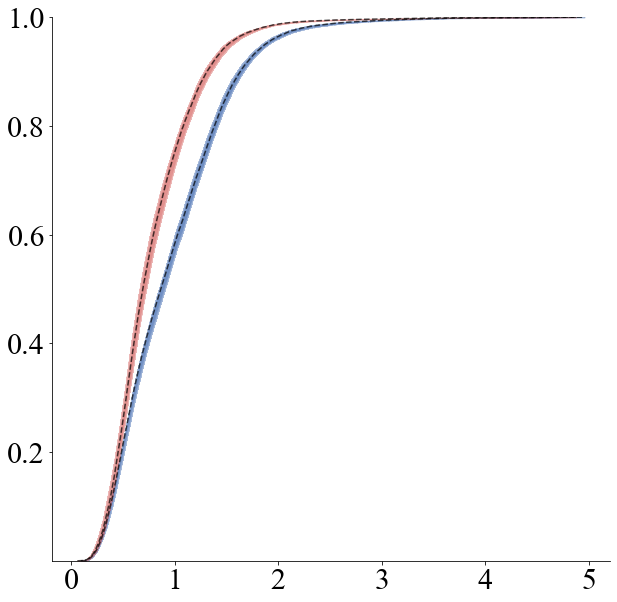

In [108]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

for ms in [0,1]:
    ax.plot(x_all_speeds[ms][:-1],1-y_ebs_speeds[ms][:-1,0], color='k', ls='--', alpha=0.7)
    ax.fill_between(x_all_speeds[ms][:-1], 1-y_ebs_speeds[ms][:-1,1], 1-y_ebs_speeds[ms][:-1,2], alpha=0.4, color=st_colors[ms])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yscale('log')
# ax.set_xlabel(r'Mean speeds per bout (cm/s)',fontsize=35)
# ax.set_ylabel(r'CDF',fontsize= 40)
# ax.legend(loc="upper left",bbox_to_anchor=(1.0, 1.05), fontsize=40, ncol=2)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.set_xlim(-1,3)
ax.set_ylim(1e-4,1)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/RC_speeds.pdf')
plt.show()

In [119]:
X_head[X_head==0.] = ma.masked

In [120]:
print(X_head.shape)

(218, 946, 40, 2)


In [121]:
distort_traj = ma.array(distorted_eigfs[:,0])[final_labels]
distort_traj[final_labels.mask] = ma.masked
dtrajs_fish_phi2 = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

808
(801,)


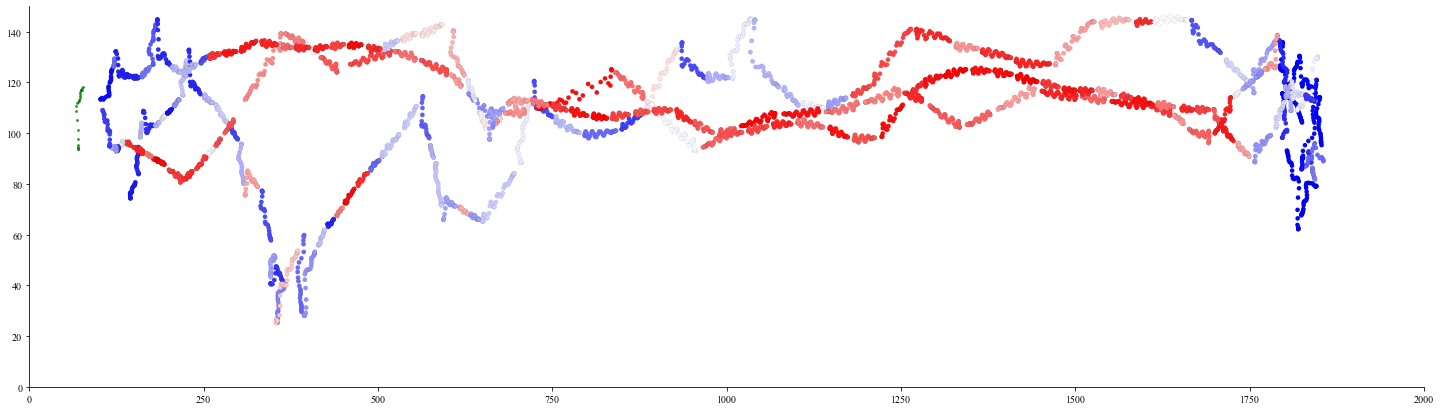

In [135]:
fig, ax = plt.subplots(1,1,figsize=(25,7))
# phi_traj_fish = eigfunctions_traj[:,1].reshape(labels_fish.shape[0], labels_fish.shape[1])
eigfish = dtrajs_fish_phi2
# eigfish = cluster_fish_condition

rec = 92
st = 0
en = 200#len(eigfish[rec].compressed())

print(lengths_all[rec])
print(eigfish[rec].compressed().shape)

colors_ = eigfish[rec,st:en]
# print(colors_)
colors_ = ma.repeat(colors_[:,np.newaxis],X_head.shape[2],axis=1)
divnorm = pltcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1.)

X_toplot = X_head[rec,st:en,:,0]
Y_toplot = X_head[rec,st:en,:,1]

# print(X_toplot.shape)

im = ax.scatter(ma.hstack(Y_toplot),ma.hstack(X_toplot),alpha=1.,c = colors_,ec='k', linewidths=0.05,s = 20., norm=divnorm, cmap='bwr_r')
# im = ax.scatter(ma.hstack(X_toplot),ma.hstack(Y_toplot),alpha=1.,c = np.arange(0,colors_.size),s = 3., cmap='viridis')
im = ax.scatter(ma.hstack(X_toplot[0]),ma.hstack(Y_toplot[0]),alpha=.75,c = 'g',s = 3.)
# im = ax.scatter(ma.hstack(X_toplot[-1]),ma.hstack(Y_toplot[-1]),alpha=.75,c = 'k',s = 3.)

# x_stacks = ma.hstack(X_toplot)
# y_stacks = ma.hstack(Y_toplot)

# for i in range(0,len(x_stacks)-50,50):
#     ax.arrow(x_stacks[i],y_stacks[i],x_stacks[i+50] - x_stacks[i],y_stacks[i+50]-y_stacks[i],color='k',width = 1.5,alpha=0.15, head_width=10.5, head_length = 10.5, length_includes_head=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(4)
# ax.set_xticks([0,950])
# ax.set_xticklabels(['',''], fontsize=30)
# ax.set_yticks([0,950])
# ax.set_yticklabels(['',''], fontsize=30)
# ax.set_ylabel('y', fontsize=20)
# ax.axis('equal')
# ax.plot(50*np.ones((2,)),[0,150], c='k')

ax.set_xlim(0,2000)
ax.set_ylim(0,150)
# ax.axis('equal')
# ax.axis('off')

# ax.set_title('Trajectories',fontsize=20)
# cb = fig.colorbar(im)
# cb.set_label(r'$\phi_{2}$',size=50)
#         ax[ks].set_x ticklabels([])
#         ax[ks].set_yticklabels([])
#     plt.ylim(0,2500)
# plt.xlabel('x',fontsize=20)
# plt.tight_layout()
# plt.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/example_WC_traj1.png', dpi=300)
plt.show()